In [36]:
%reload_ext autoreload
%autoreload 2

from glob import glob

import numpy as np
import cv2

from tqdm import tqdm

from scipy import spatial

import torch
from torch.utils.data import Dataset, DataLoader, sampler

import torchvision.datasets as dset
from torchvision import transforms

from skimage import draw, io, exposure, morphology, transform

from PIL import Image

from matplotlib import pylab as plt

from joblib import Parallel, delayed
import multiprocessing

import dataprep
import mysegmentation as myseg
import psdio

from jupyterthemes import jtplot
jtplot.style(theme='chesterish', context='talk',
             fscale=1.4, spines=False, grid=False)

In [2]:
psd_path  = "../annotations/contaminants/raw_layerpercell/V2/"
psd_paths = sorted(glob(psd_path+"*.psd"))

In [9]:
psd0 = psdio.psd_layesrs_to_npy(psd_paths[-1])

100%|██████████| 222/222 [00:34<00:00,  6.41it/s]


In [28]:
psd0 = psdio.large_psd_to_npy(psd_paths[-1])

In [32]:
image, layers = psdio.get_masks_from_layer(psd0)
conts, cells  = layers[0], layers[1:] 


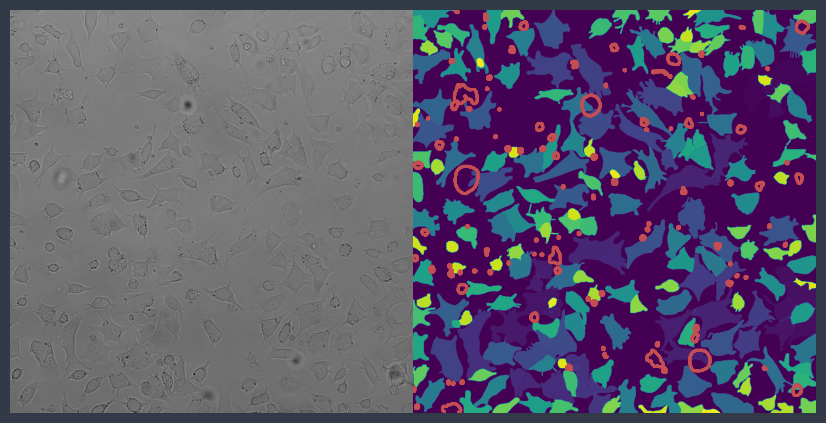

In [33]:
plt.subplot(121)
plt.imshow(image), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(np.sum(cells.T*np.arange(1,cells.shape[0]+1),2).T), plt.xticks([]), plt.yticks([])
plt.contour(conts,colors="r")
plt.subplots_adjust(wspace=0)

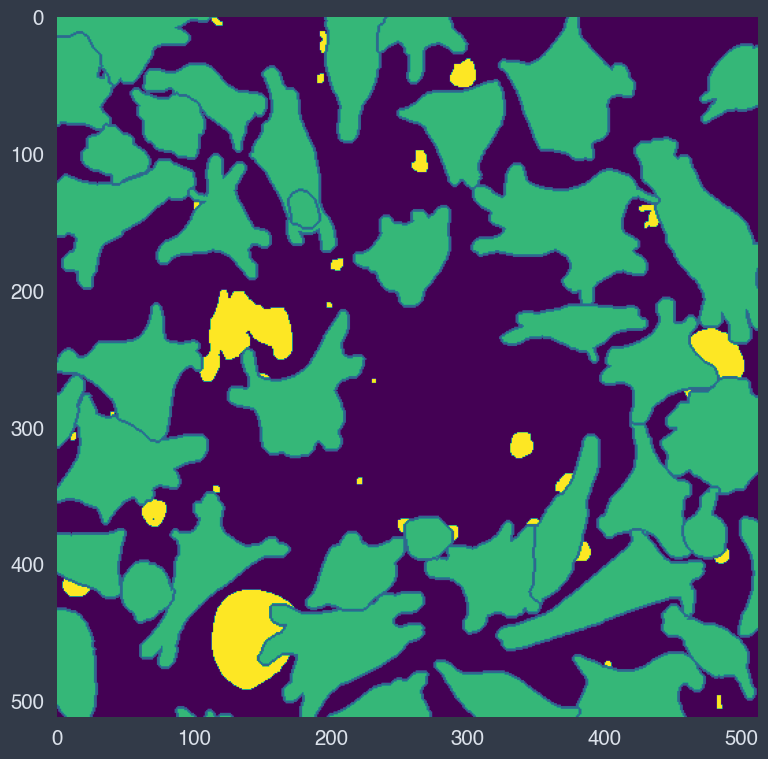

In [41]:
cells512 = cells[:,:512,:512]
conts512 = conts[:512,:512]*3
outlines = dataprep.outline_mask(cells512)
conts512[outlines==1] = 1
conts512[outlines==2] = 2

plt.imshow(conts512)

In [ ]:
out_path = "../annotations/contaminants/raw_layerpercell/trainingdata/V2/"
lims     = (np.arange(1,10)*50).astype(int)

#def augmentations(in_path,outpath,lims):

def process_image(image,masks,out_path,lims):
    
    dimages, dmasks = [], []
    for i in range(10):
        di,dm = dataprep.distort_all(image,masks,10,2.,20,0.1*i)
        dimages.append(di)
        dmasks.append(dm)
    
    image_crops, mask_crops = np.stack(dimages), np.stack(dmasks)

    def process_all(ind):

        size = 512

        lw = 2

        for n, i in enumerate(lims):
            ic = image_crops[ind]
            ic = image_crop_resize(ic, c=i, size=size)
            ic = ic.astype("uint8")

            im = mask_crops[ind]
            im = dataprep.mask_crop_resize(im, c=i, size=size)
            im = dataprep.outline_mask(im, lw*size/(size-i))*100
            im = im.astype(uint8)

            io.imsave(out_path+str(10000000+ind*100+n)[1:]+"raw.png", ic)
            io.imsave(out_path+str(10000000+ind*100+n)[1:]+"mask.png", im)

            for j in list(range(1, 4)):
                io.imsave(out_path+str(10000000+ind*100+n+10*j)
                            [1:]+"raw.png", np.rot90(ic, j))
                io.imsave(out_path+str(10000000+ind*100+n+10*j)
                            [1:]+"mask.png", np.rot90(im, j))

                io.imsave(out_path+str(10000000+ind*100+n+10*j+30)
                            [1:]+"raw.png", np.rot90(ic.T, j))
                io.imsave(out_path+str(10000000+ind*100+n+10*j+30)
                            [1:]+"mask.png", np.rot90(im.T, j))

                io.imsave(out_path+str(10000000+ind*100+n+10*j+60)
                            [1:]+"raw.png", np.rot90(ic[::-1].T, j))
                io.imsave(out_path+str(10000000+ind*100+n+10*j+60)
                            [1:]+"mask.png", np.rot90(im[::-1].T, j))

    _ = mCPU(process_all, range(len(dimages)), 20)

    



In [46]:
np.round((np.zeros((10,10))+255).astype("uint8")/100,0)

array([[3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]])